In [2]:
#Import des librairies utiles
from bs4 import BeautifulSoup
import time
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional, TimeDistributed, RepeatVector, Flatten
from keras.callbacks import EarlyStopping

In [3]:
#fonction de scraping des tirages du loto
def scrap_loto_numbers():
    my_list=[]
    time.sleep(2)
    loto_url = "http://loto.akroweb.fr/loto-historique-tirages/"
    page = requests.get(loto_url)
    soup = BeautifulSoup(page.text, 'html.parser')
    body = soup.find('table')
    tirage_line = body.find_all('tr')
    for value in tirage_line:
        my_dict = {}
        res = value.text.split('\n')
        my_dict['day']=res[2]
        my_dict['month_year']=res[3]

        for i,val in enumerate(res[5:10]):
            my_dict['num'+str(i)]=int(val)
        my_dict['chance']=int(res[10])
        my_list.append(my_dict)


    df=pd.DataFrame(my_list)
    return df

In [4]:
#sracping des tirages actuellement disponibles sur le site 
df_tirage=scrap_loto_numbers()
df_tirage[['day','month_year','num0','num1','num2','num3','num4','chance']].head()
#suppression  des tirages du super loto( A explorer later )
#df_tirage=df_tirage[(df_tirage['day']!='Vendredi') & (df_tirage['day']!='Mardi')]

,day,month_year,num0,num1,num2,num3,num4,chance
0,Lundi,01 mai 2023,5,15,33,41,44,10
1,Samedi,29 avril 2023,3,22,36,40,48,5
2,Mercredi,26 avril 2023,3,11,14,18,24,10
3,Lundi,24 avril 2023,1,23,25,41,49,2
4,Samedi,22 avril 2023,12,13,26,35,48,1


In [5]:
#df_tirage=df_tirage.tail(df_tirage.shape[0])# suppression du dernier tirage/à éviter selon le cas 
df_tirage.head()# le dernier tirage devient ici celui du 26

,day,month_year,num0,num1,num2,num3,num4,chance
0,Lundi,01 mai 2023,5,15,33,41,44,10
1,Samedi,29 avril 2023,3,22,36,40,48,5
2,Mercredi,26 avril 2023,3,11,14,18,24,10
3,Lundi,24 avril 2023,1,23,25,41,49,2
4,Samedi,22 avril 2023,12,13,26,35,48,1


In [6]:
df = df_tirage.iloc[::-1]#inversion du dataframe pour placer le dernier tirage en dernière position
df = df[['num0', 'num1', 'num2', 'num3', 'num4', 'chance']]#sélection des numéros à  traiter

In [7]:
df.tail()# notre tirage du 26 ici devient le dernier de notre dataset afin de pourvoir organiser les data par historique

,num0,num1,num2,num3,num4,chance
4,12,13,26,35,48,1
3,1,23,25,41,49,2
2,3,11,14,18,24,10
1,3,22,36,40,48,5
0,5,15,33,41,44,10


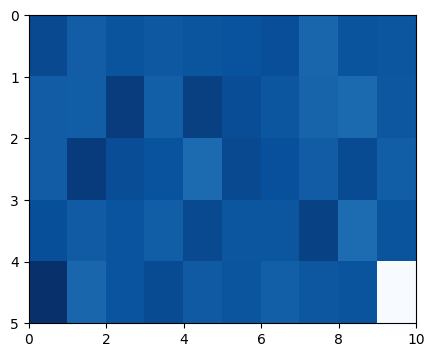

In [8]:
def is_under(data, number):
    return ((data['num0'] <= number).astype(int) + 
            (data['num1'] <= number).astype(int) +
            (data['num2'] <= number).astype(int) +
            (data['num3'] <= number).astype(int) +
            (data['num4'] <= number).astype(int))

#fonction de vérification de nombres pairs pour les 5 premiers numéros sauf celui de chance
def is_pair(data):
    return ((data['num0'].isin(pairs)).astype(int) + 
            (data['num1'].isin(pairs)).astype(int) +
            (data['num2'].isin(pairs)).astype(int) +
            (data['num3'].isin(pairs)).astype(int) +
            (data['num4'].isin(pairs)).astype(int))

#fonction de vérification de nombres impairs pour les 5 premiers numéros sauf celui de chance
def is_impair(data):
    return ((data['num0'].isin(impairs)).astype(int) + 
            (data['num1'].isin(impairs)).astype(int) +
            (data['num2'].isin(impairs)).astype(int) +
            (data['num3'].isin(impairs)).astype(int) +
            (data['num4'].isin(impairs)).astype(int))

#fonction de vérification de nombres pairs pour le numéro de chance
def is_pair_etoile(data):
    return (data['chance'].isin(pairs)).astype(int)

#fonction de vérification de nombres impairs pour le numéro de chance
def is_impair_etoile(data):
    return (data['chance'].isin(impairs)).astype(int)

#liste de nombres pairs et impairs
pairs = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50]
impairs = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49]

#Fonction de calcul de la somme de la différence au carré des 5 premiers numéros, sauf celui de chance
def sum_diff(data):
    return ((data['num1'] - data['num0'])**2 + 
            (data['num2'] - data['num1'])**2 +
            (data['num3'] - data['num2'])**2 +
            (data['num4'] - data['num3'])**2)


# Calcul de la fréquence de tirage de chaque numéro
freqs = []
for val in range(50):
    count = ( (df['num0'] == val+1).sum() +
              (df['num1'] == val+1).sum() +
              (df['num2'] == val+1).sum() +
              (df['num3'] == val+1).sum() +
              (df['num4'] == val+1).sum() )
    freqs.append(count)
ax = plt.gca() ;  ax.invert_yaxis()
plt.gcf().set_size_inches(5, 4)
heatmap = plt.pcolor(np.reshape(np.array(freqs), (5, 10)), cmap=plt.cm.Blues)

def freq_val(data, column):
    tab = data[column].values.tolist()
    freqs = []
    pos = 1
    for e in tab:
        freqs.append(tab[0:pos].count(e))
        pos = pos + 1
    return freqs



#df['sum'] = ((df.num0 + df.num1 + df.num2 + df.num3 + df.num4 + df.chance ) >185).astype(int)

In [9]:
#ajout de la difference entre les numéros(A explorer ASAp)
#for i in range(4):
    #print(i,i+1)
    #df['diff_{}'.format(i)]=df['num{}'.format(i+1)]-df['num{}'.format(i)]
#application des fonctions sur le dataframe
df['freq_num0'] = freq_val(df, 'num0')
df['freq_num1'] = freq_val(df, 'num1')
df['freq_num2'] = freq_val(df, 'num2')
df['freq_num3'] = freq_val(df, 'num3')
df['freq_num4'] = freq_val(df, 'num4')
df['freq_chance'] = freq_val(df, 'chance')#calcul des frequences 
df['sum_diff'] = sum_diff(df)#somme de la différence au carré entre chaque couple de numéros successifs dans le tirage
df['pair_chance'] = is_pair_etoile(df)
df['impair_chance'] = is_impair_etoile(df)
df['pair'] = is_pair(df)
df['impair'] = is_impair(df)#verification de nombre pair et impair
df['is_under_24'] = is_under(df, 24)  # Les numeros en dessous de 24 
df['is_under_40'] = is_under(df, 40)# Les numeros en dessous de 40 
df.head(6)

,num0,num1,num2,num3,num4,chance,freq_num0,freq_num1,freq_num2,freq_num3,freq_num4,freq_chance,sum_diff,pair_chance,impair_chance,pair,impair,is_under_24,is_under_40
2331,19,24,27,33,41,9,1,1,1,1,1,1,134,0,1,1,4,2,4
2330,22,24,32,41,48,1,1,2,1,1,1,1,198,0,1,4,1,2,3
2329,10,20,22,39,46,4,1,1,1,1,1,1,442,1,0,4,1,3,4
2328,10,11,37,41,48,4,2,1,1,2,2,2,742,1,0,2,3,2,3
2327,18,20,28,40,49,1,1,2,1,1,1,2,293,0,1,4,1,2,4
2326,4,32,35,39,44,10,1,1,1,2,1,1,834,1,0,3,2,1,4


In [10]:
# j'ai ici défini plusieurs modèles à tester mais pour l'intant je tavaille avec le lstm(fonction : define_model)
# j'ai ici défini window_length à 12 pour apprendre sur 1 mois de données 

#Params du modèle
nb_label_feature=6

UNITS = 100
BATCHSIZE = 30
EPOCH = 1500
#ACTIVATION = "softmax"
OPTIMIZER ='adam' # rmsprop, adam, sgd
LOSS = 'mae'#'categorical_crossentropy' #mse
DROPOUT = 0.1
window_length = 12 #12 
number_of_features = df.shape[1]

#Architecture du modèle
def define_model(number_of_features,nb_label_feature):
    #initialisation du rnn
    model = Sequential()
    #ajout de la premiere couche lstm
    model.add(LSTM(UNITS, input_shape=(window_length, number_of_features), return_sequences=True))
    model.add(LSTM(UNITS, dropout=0.1, return_sequences=False))
    #ajout de la couche de sortie
    model.add(Dense(nb_label_feature))
    model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=['acc'])
    return model

In [11]:
def define_bidirectionnel_model(number_of_features,nb_label_feature):
    model = Sequential()
    model.add(Bidirectional(LSTM(100, dropout=0.2, return_sequences=True), input_shape=(window_length, number_of_features)))
    model.add(LSTM(50, return_sequences=True))
    model.add(LSTM(100, dropout=0.1))
    model.add(Dense(nb_label_feature))
    model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=['acc'])
    return model

def define_autoencoder_model(number_of_features,nb_label_feature):
    model = Sequential()
    model.add(LSTM(100, input_shape=(window_length, number_of_features), return_sequences=True))
    model.add(LSTM(50, return_sequences=False))
    model.add(RepeatVector(window_length))
    model.add(LSTM(100, dropout=0.1, return_sequences=True))
    model.add(LSTM(50, return_sequences=True))
    model.add(TimeDistributed(Dense(number_of_features)))
    model.add(Flatten())
    model.add(Dense(nb_label_feature))
    model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=['acc'])
    return model



#model = define_model(number_of_features,nb_label_feature)
#model3 = define_autoencoder_model(number_of_features,nb_label_feature)
#model4 = define_bidirectionnel_model(number_of_features,nb_label_feature)

#Moniteur pour stoper le training
es = EarlyStopping(monitor='acc', mode='max', verbose=1, patience=100)

In [12]:
# Fonction de formatage des données en entrée du LSTM
def create_lstm_dataset(df, window_length,nb_label_feature):
    number_of_rows = df.shape[0]   #taille du dataset number_of_features
    number_of_features = df.shape[1]
    scaler = StandardScaler().fit(df.values)
    transformed_dataset = scaler.transform(df.values)
    transformed_df = pd.DataFrame(data=transformed_dataset, index=df.index)
    #tableau de tableau de taille(number_of_rows-window_length) et window_length ligne,number_of_features
    #lstm:[nb total de row ,nb de ligne dans le passé, nb de colonne(feature)]
    train = np.empty([number_of_rows-window_length, window_length, number_of_features], dtype=float)
    
    label = np.empty([number_of_rows-window_length, nb_label_feature], dtype=float)
    for i in range(0, number_of_rows-window_length):
        train[i] = transformed_df.iloc[i:i+window_length, 0: number_of_features]
        label[i] = transformed_df.iloc[i+window_length: i+window_length+1, 0:nb_label_feature]
        
    #définition du modèle Lstm  
    model = define_model(number_of_features,nb_label_feature)
        
    return train, label, model,scaler

In [13]:
#formatage des données
train, label,model,scaler1 = create_lstm_dataset(df, window_length,nb_label_feature)
print(train.shape)
print(label.shape)

(2320, 12, 19)
(2320, 6)


In [14]:
#Training
history=model.fit(train, label, batch_size=BATCHSIZE, epochs=EPOCH, verbose=2, callbacks=[es])

Epoch 1/1500
78/78 - 10s - loss: 0.8137 - acc: 0.1431 - 10s/epoch - 124ms/step
Epoch 2/1500
78/78 - 0s - loss: 0.8080 - acc: 0.1474 - 399ms/epoch - 5ms/step
Epoch 3/1500
78/78 - 0s - loss: 0.8059 - acc: 0.1638 - 387ms/epoch - 5ms/step
Epoch 4/1500
78/78 - 0s - loss: 0.8055 - acc: 0.1685 - 404ms/epoch - 5ms/step
Epoch 5/1500
78/78 - 0s - loss: 0.8031 - acc: 0.1612 - 384ms/epoch - 5ms/step
Epoch 6/1500
78/78 - 0s - loss: 0.8007 - acc: 0.1802 - 404ms/epoch - 5ms/step
Epoch 7/1500
78/78 - 0s - loss: 0.7984 - acc: 0.1931 - 423ms/epoch - 5ms/step
Epoch 8/1500
78/78 - 0s - loss: 0.7960 - acc: 0.1927 - 414ms/epoch - 5ms/step
Epoch 9/1500
78/78 - 0s - loss: 0.7926 - acc: 0.1991 - 403ms/epoch - 5ms/step
Epoch 10/1500
78/78 - 0s - loss: 0.7856 - acc: 0.2103 - 392ms/epoch - 5ms/step
Epoch 11/1500
78/78 - 0s - loss: 0.7787 - acc: 0.2086 - 379ms/epoch - 5ms/step
Epoch 12/1500
78/78 - 0s - loss: 0.7693 - acc: 0.2328 - 392ms/epoch - 5ms/step
Epoch 13/1500
78/78 - 0s - loss: 0.7576 - acc: 0.2435 - 403m

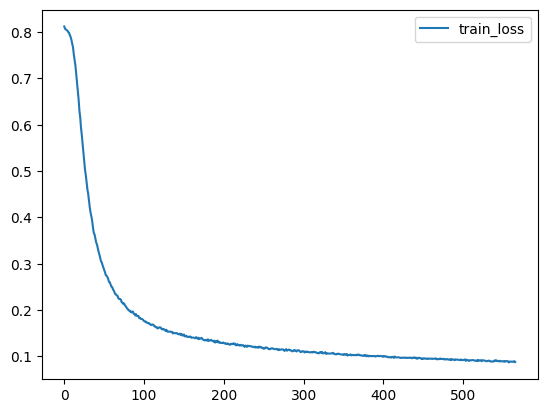

In [ ]:
plt.plot(history.history['loss'])
plt.legend(['train_loss'])
plt.show()

In [15]:
window_length = 12 # sur 2290 tirages

last_twelve = df.tail(window_length) # on recupere les 12 derniers tirages
scaler = StandardScaler().fit(df.values)
scaled_to_predict = scaler.transform(last_twelve)
scaled_predicted_output_1 = model.predict(np.array([scaled_to_predict]))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


1/1 [==============================] - 1s 613ms/step


In [16]:
#prediction
tom = df.tail(window_length).iloc[:,0:6] # 
scaler = StandardScaler().fit(df.iloc[:,0:6])
scaled_to_predict = scaler.transform(tom)
print(scaler.inverse_transform(scaled_predicted_output_1).astype(int)[0])

[ 5 12 22 31 42  9]


03/05 : 
5 12 22 31 42  9


27/02 : 

Prédiction 12 pour 12 (loss: 0.0822 - acc: 0.9188) : [ 7 12 24 35 46  7]

23/02 au macdo :       

Prédiction 1 pour 1 : [ 6  8 21 28 41  4]
Prédiction 2 pour 1 : [ 5 14 28 32 41  2]
Prédiction 3 pour 1 : [14 19 28 33 45  6]
Prédiction 4 pour 1 : [16  8 17 21 46  4]
Prédiction 5 pour 1 : [13 13 24 23 47  6]
Prédiction 12 pour 1 : [ 8 13 22 23 40  8]

Prédiction 1 pour 2 : [ 7 20 31 35 40  6]
Prédiction 2 pour 2 : [ 5 17 30 37 45  8]
Prédiction 4 pour 2 : [-1 11 21 26 38  7]
Prédiciton 5 pour 2 : [ 3 18 28 30 35  6]
Prédiction 12 pour 2 : [ 2 11 23 32 36  5]
Prédiction 50 pour 2 : [ 6 11 16 29 36  6]
Prédiction 100 pour 2 : [ 5 15 22 31 36  3]

Prédiction 1 pour 3 : [ 7 17 31 36 43  6]
Prédiction 2 pour 3 : [ 7 22 33 41 46  7]
Prédiction 3 pour 3 : [ 9 19 23 34 41  5]

Prédiction 1 pour 5 : [ 7 18 27 37 44  5]
Prédiction 2 pour 5 : [ 9 19 31 40 46  5]
Prédiction 5 pour 5 : [10 18 28 36 45  6]
Prédiction 12 pour 5 : [ 6 10 15 30 39  7]
Prédiction 50 pour 5 : [ 9 19 28 30 43  5]
Prédiction 100 pour 5 : [ 5 22 33 38 43  3]
Prédiction 200 pour 5 : [ 7 13 31 37 44  3]
Prédiction 300 pour 5 : [11 17 27 41 45  3]
Prédiction 500 pour 5 : [ 7 19 28 37 42  3]
Prédiction 800 pour 5 : [ 4  7 28 38 47  5]
Prédiction 1000 pour 5 : [ 8 13 30 40 48  4]
Prédiction 1500 pour 5 : [ 9 23 31 44 43  3]
Prédiction 2000 pour 5 : [ 8 18 24 40 45  3]
Prédiction 2290 pour 5 : [ 8 19 28 37 45  3]
Prediction 2500 pour 5 : [ 8 13 29 40 49  4]
Prediction 3000 pour 5 : [ 8 13 29 40 49  4]

Prédiction 12 pour 12 : [ 9 21 32 37 46  5]
Prédiction 100 pour 12 : [ 5 16 25 35 42  2]
Prédiction 300 pour 12 : [10 15 23 38 42  4]

Prédiction 1 pour 100 : [ 8 14 24 36 44  6]
Prédiction 2 pour 100 : [10 16 28 40 45  7]
Prédiction 3 pour 100 : [ 6 10 24 38 43  6]
Prédiction 4 pour 100 : [ 6 17 26 41 43  6]
Prédiction 5 pour 100 : [10 23 32 40 41  3]
Prédiction 12 pour 100 : [12 19 29 34 45  6]
Prédiction 30 pour 100 : [12 23 31 39 41  3]
Prédiction 100 pour 100 : [ 8 26 30 36 42  2]
Prédiction 200 pour 100 : [ 8 26 30 36 42  2]
Prédiction 300 pour 100 : [ 8 26 30 36 42  2]

Prédiction 1 pour 300 : [ 6 15 27 36 43  6]
Prédiction 2 pour 300 : [ 6 16 25 36 46  5]
Prédiction 3 pour 300 : [ 5 16 23 36 46  6]
Prédiction 4 pour 300 : [ 8 18 32 42 44  7]
Prédiction 5 pour 300 : [ 4 12 21 34 43  6]
Prédiction 12 pour 300 : [ 4 19 25 35 43  8]
Prédiction 300 pour 300 : [ 8 18 26 38 44  3]
Prédiction 500 pour 300 : [ 8 18 26 38 44  3]

21/02 : pour un apprentissage sur 100.

*    [ 8 15 25 36 42  5] pour 10 derniers
*    [11 13 20 36 45  4] pour 20 derniers
*    [12 16 21 33 44  4] pour 30 derniers
*    [11 17 21 33 43  4] pour 40 derniers
*    [11 17 21 33 43  4] pour 50 derniers
*    [11 16 21 33 43  4] pour 60 derniers
*    [11 16 21 33 43  4] pour 70 derniers
*    [11 16 21 33 43  4] pour 80 derniers
*    [11 16 21 33 43  4] pour 90 derniers
*    [11 16 21 33 43  4] pour 100 derniers

....................................

*    [11 17 21 33 43  4] pour 50 derniers
*    [11 16 21 33 43  4] pour 100 derniers
*    [11 16 21 33 43  4] pour 300 derniers
*    [11 16 21 33 43  4] pour 500 derniers
*    pour 800 derniers
*    pour 1000 derniers
*    pour 1500 derniers
*    pour 2000 derniers
*    [11 16 21 33 43  4] pour 2290 derniers

21/02 : pour un apprentissage sur 12.

*   [ 3 10 17 27 39  5] pour 1 derniers
*   [14 21 26 34 43  5] pour 2 derniers
*   [11 16 23 30 39  4] pour 3 derniers
*   [ 5 11 24 33 41  6] pour 4 derniers
*   [13 15 25 35 41  4] pour 5 derniers
*   [11 22 36 45 44  3] pour 6 derniers
*   [ 9 19 32 41 46  6] pour 7 derniers
*   [11 19 24 37 45  3] pour 8 derniers
*   [10 11 22 30 42  6] pour 9 derniers
*   [ 7 15 23 36 45  5] pour 10 derniers
*   [ 6 14 23 38 41  6] pour 11 derniers
*   [19 25 34 40 45  3] pour 12 derniers

....................................

*   [19 25 34 40 45  3] pour 12 derniers
*   [12 19 33 40 42  7] pour 50 derniers
*   [12 19 31 43 43  5] pour 100 derniers
*   [11 20 32 41 43  7] pour 300 derniers
*   [11 18 33 42 42  6] pour 500 derniers
*   [11 18 34 42 42  6] pour 800 derniers
*   [11 19 32 41 43  6] pour 1000 derniers
*   [11 19 32 41 43  6] pour 1500 derniers
*   [11 19 32 41 43  6] pour 2000 derniers
*   [11 19 32 41 43  6] pour 2290 derniers

In [ ]:
# most frequently predicted

